# Расшифровка VIN-кодов автомобилей при помощи регулярных выражений

**Описание проекта**
Изучение информации, зашифрованной в VIN-кодах с целью прогнозирования цены.

**Цель проекта**
- Составление прогноза цен для автомобилей FORD на основании информации скрытой в VIN-кодах.

**Задачи**
- изучить структуру VIN-кода: какие информационные компоненты он содержит (регион, производитель, характеристики автомобиля и т. д.);
- составлять регулярные выражения для поиска и извлечения конкретных частей VIN-кода, таких как производитель, модель и год выпуска;
- распарсить текстовый массив данных с VIN-кодами и ценами;
- решить задачу предсказания цены по VIN-коду.

**Метрики**
- `MSE`, `MAE`, `MAPE`, `R2`

**Ход исследования**
- Ознакомление с данными;
- ознакомление со способами кодирования данных в VIN-кодах;
- составление паттерна для парсинга VIN-кодов;
- проверка работоспособности паттерна;
- парсинг VIN-кодов;
- подготовка данных для модели;
- обучение baseline модели;
- обучение других моделей;
- выбор лучшей модели;
- проверка важности признаков;
- заключение по исследованию.

**Справочная информация**
- https://docs.python.org/3/library/re.html
- https://regex101.com
- https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)#Table_of_Contents
- https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/World_Manufacturer_Identifier_(WMI)
- https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Printable_version#Model#
- https://en.wikipedia.org/wiki/List_of_Ford_factories

**Форматы VIN-кодов**

![варианты vin кодов](data/photo_5269222301897973406_x.jpg)

Настройка среды

In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install mlflow
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install phik
# !pip install catboost
# !pip install shap
!pip freeze > requirements.txt

In [2]:
import re
import os
import pandas as pd
import psycopg2 as psycopg

from dotenv import load_dotenv

Установка глобальных переменных

In [3]:
RANDOM_STATE = 42
ASSETS_DIR = 'assets'
DATA_PATH = 'data/vin_ford_train.txt'
TRACKING_SERVER_PORT = 5000
TRACKING_SERVER_HOST = "127.0.0.1"
EXPERIMENT_NAME = 'vin_codes'
RUN_NAME = ['baseline_0_registry', 'lr_0_registry', 'rf_0_registry', 'cb_0_registry']
REGISTRY_MODEL_NAME = ['baseline', 'linear_regression', 'rendom_forest', 'catboost']

load_dotenv()
connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}

Импорт класса для проведения исследования

In [4]:
%load_ext autoreload
%autoreload 2

from research_class import DatasetExplorer

## Знакомство с данными

In [5]:
with open (DATA_PATH, 'r') as f:
    data = f.read()
print(data[:400])

[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK


### Выводы и наблюдения
- исходя из условий задачи, необходимый вариант VIN-кодов - `American VIN format`;
- в предоставленном файле VIN-коды находятся в неудобном для исследования формате:
  - необходима очистка и преобразование;
- помимо VIN-кодов в файле предоставлены цены.

## Подготовка паттерна
В соответствии с правилами составления VIN-кодов для американских автомобилей:
- современные VIN-коды состоят из 17 символов, которые не содержат букв I, O или Q;
- `check digit` - 0-9 or X;
- буквы U и Z и цифра 0 не используются для кода года;
- позиции 13–17 должны быть цифрами, тогда как позиция 12 может быть буквой или цифрой

### Разрешённые в VIN-кодах символы

In [6]:
allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

### Тестовый образец

In [7]:
vin_sample = '1FT7X2B6XCEB34867 1FTNF1CF4EKD18628 1GNKRFED3CJ319802 5N1BA08D49N601792 5TFHY5F19CX236781 JN1CV6AR7BM356524 ZFF65LJA9A0170669'
vin_sample

'1FT7X2B6XCEB34867 1FTNF1CF4EKD18628 1GNKRFED3CJ319802 5N1BA08D49N601792 5TFHY5F19CX236781 JN1CV6AR7BM356524 ZFF65LJA9A0170669'

### Северо-Американский формат VIN

In [8]:
wmi_pattern = r'(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})'  # pos. 1-3
brake_pattern = r'(?P<brake>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])' # pos. 4
body_pattern = r'(?P<body>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})'  # pos. 5-7
engine_pattern = r'(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'  # pos. 8
check_digit_pattern = r'(?P<check_digit>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'  # pos. 9
year_pattern = r'(?P<year>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'.replace('U', '').replace('Z', '').replace('0', '')  # pos. 10
plant_pattern = r'(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'  # pos. 11
snum_pattern = r'(?P<snum>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]\d{5})'  # pos. 12-17
pattern = f'{wmi_pattern}{brake_pattern}{body_pattern}{engine_pattern}{check_digit_pattern}{year_pattern}{plant_pattern}{snum_pattern}'
pd.DataFrame([x.groupdict() for x in re.compile(pattern).finditer(vin_sample)])

,wmi,brake,body,engine,check_digit,year,plant,snum
0,1FT,7,X2B,6,X,C,E,B34867
1,1FT,N,F1C,F,4,E,K,D18628
2,1GN,K,RFE,D,3,C,J,319802
3,5N1,B,A08,D,4,9,N,601792
4,5TF,H,Y5F,1,9,C,X,236781
5,JN1,C,V6A,R,7,B,M,356524
6,ZFF,6,5LJ,A,9,A,0,170669


### Извлечение производителя из VIN-кода

In [9]:
pattern = r'''
    \b(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})  # три первые элемента слова, принадлежащие такому набору
    [ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{14}\b          # исключение 14-ти последующих элементов слова, принадлежащих набору
'''
re.compile(pattern, re.X).findall(vin_sample)

['1FT', '1FT', '1GN', '5N1', '5TF', 'JN1', 'ZFF']

### Поиск всех VIN-кодов определенной марки автомобиля на примере Ferrari
- Вин-коды Феррари ZDF, ZFF, ZSG

In [10]:
ferrari_wmi = ['ZDF', 'ZFF', 'ZSG']
wmi_pattern = '|'.join(ferrari_wmi)
pattern = re.compile(f'\\b(?:{wmi_pattern})[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{{14}}\\b')
pattern.findall(vin_sample)

['ZFF65LJA9A0170669']

### Поиск VIN-кодов с определенным регионом
Северная Америка как регион (США, Канада, Мексика)

    1, 4, 5 = United States
    2 = Canada
    3 = Mexico
    7F-70 = United States

Североамериканские машины

In [11]:
pattern = r'''
    \b(?:1|4|5|7F|70)[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{16}\b
    |\b2[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{16}\b
    |\b3[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{16}\b
    '''
re.compile(pattern, re.X).findall(vin_sample)

['1FT7X2B6XCEB34867',
 '1FTNF1CF4EKD18628',
 '1GNKRFED3CJ319802',
 '5N1BA08D49N601792',
 '5TFHY5F19CX236781']

Машины из любых других регионов (не Сев.Америка)

In [12]:
pattern = re.compile(r'\b(?!(?:1|4|5|7F|70|2|3)[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{16})[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{17}\b')
pattern.findall(vin_sample)

['JN1CV6AR7BM356524', 'ZFF65LJA9A0170669']

### Извлечение года из VIN-кода только североамериканских машин
- В североамериканском вине год 10й знак
- в кодировке года не используются знаки U и Z в дополнение к запрещенным I, O, Q

In [13]:
pattern = r'''
    \b(?:1|4|5|7F|70)[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{16}\b
    |\b2[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{16}\b
    |\b3[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{16}\b
'''
[x[9] for x in re.compile(pattern, re.X).findall(vin_sample)]

['C', 'E', 'C', '9', 'C']

Для проверки выведем весь датафрейм компонентов VIN кода

In [14]:
wmi_pattern = r'(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})'  # pos. 1-3
brake_pattern = r'(?P<brake>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])' # pos. 4
body_pattern = r'(?P<body>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})'  # pos. 5-7
engine_pattern = r'(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'  # pos. 8
check_digit_pattern = r'(?P<check_digit>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'  # pos. 9
year_pattern = r'(?P<year>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'.replace('U', '').replace('Z', '').replace('0', '')  # pos. 10
plant_pattern = r'(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])'  # pos. 11
snum_pattern = r'(?P<snum>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]\d{5})'  # pos. 12-17
pattern = f'{wmi_pattern}{brake_pattern}{body_pattern}{engine_pattern}{check_digit_pattern}{year_pattern}{plant_pattern}{snum_pattern}'
pd.DataFrame([x.groupdict() for x in re.compile(pattern).finditer(vin_sample)])

,wmi,brake,body,engine,check_digit,year,plant,snum
0,1FT,7,X2B,6,X,C,E,B34867
1,1FT,N,F1C,F,4,E,K,D18628
2,1GN,K,RFE,D,3,C,J,319802
3,5N1,B,A08,D,4,9,N,601792
4,5TF,H,Y5F,1,9,C,X,236781
5,JN1,C,V6A,R,7,B,M,356524
6,ZFF,6,5LJ,A,9,A,0,170669


### Проверка корректности формата VIN-кода

- Вин-код состоит из 17 знаков – цифр и букв, кроме 'I', 'O', 'Q'
- Последние три знака – всегда цифры

Создадим набор винов, где только один вин валидный и остальные ошибочные
- отрежем один знак
- добавим лишний знак
- заменим буквой последнюю цифру в номере
- заменим разрешенный знак на неразрешенный

In [15]:
error_sample = vin_sample + ' 3LN6L2GKXDR811732 BAAM3334XKC59086 1N4BL11D84C1859519 1C4RJEBG5EC48287Q QN1AB7AP5EL654699'
error_sample

'1FT7X2B6XCEB34867 1FTNF1CF4EKD18628 1GNKRFED3CJ319802 5N1BA08D49N601792 5TFHY5F19CX236781 JN1CV6AR7BM356524 ZFF65LJA9A0170669 3LN6L2GKXDR811732 BAAM3334XKC59086 1N4BL11D84C1859519 1C4RJEBG5EC48287Q QN1AB7AP5EL654699'

Валидные VIN-коды

In [16]:
pattern = re.compile(r'\b[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{14}\d{3}\b')
pattern.findall(error_sample)

['1FT7X2B6XCEB34867',
 '1FTNF1CF4EKD18628',
 '1GNKRFED3CJ319802',
 '5N1BA08D49N601792',
 '5TFHY5F19CX236781',
 'JN1CV6AR7BM356524',
 'ZFF65LJA9A0170669',
 '3LN6L2GKXDR811732']

Не валидные VIN-коды

In [17]:
pattern = re.compile(r'(?!\b[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{14}\d{3}\b)\b\w+\b')

pattern.findall(error_sample)

['BAAM3334XKC59086',
 '1N4BL11D84C1859519',
 '1C4RJEBG5EC48287Q',
 'QN1AB7AP5EL654699']

### Автомобили Ford

In [18]:
ford_wmi = {
    'AFA': 'Ford Motor Company of Southern Africa & Samcor',
    'AFB': 'Mazda BT-50 made by Ford Motor Company of Southern Africa',
    'JC0': 'Ford brand cars made by Mazda',
    'JC2': 'Ford Courier made by Mazda',
    'KNJ': 'Ford Festiva & Aspire made by Kia',
    'LJX': 'JMC Ford',
    'LVS': 'Changan Ford & Changan Ford Mazda',
    'MAJ': 'Ford India',
    'MNB': 'Ford Thailand',
    'NM0': 'Ford Otosan',
    'PE1': 'Ford Motor Company Philippines',
    'PE3': 'Mazda Philippines made by Ford Motor Company Philippines',
    'PR8': 'Ford',
    'LFA': 'Ford Lio Ho Motor Co Ltd. old designation',
    'RHA': 'Ford Lio Ho Motor Co Ltd. new designation',
    'RL0': 'Ford Vietnam',
    'SBC': 'Iveco Ford Truck',
    'SFA': 'Ford UK',
    'VSK': 'Nissan Motor Iberica SA, Nissan passenger car/MPV/van/SUV/pickup & Ford Maverick 1993–1999',
    'VS6': 'Ford Spain',
    'WF0': 'Ford Germany',
    'X9F': 'Ford Motor Company ZAO',
    'Z6F': 'Ford Sollers (Russia)',
    '1FA': 'Ford car',
    '1FB': 'Ford "bus" (van with more than 3 rows of seats)',
    '1FC': 'Ford stripped chassis made by Ford',
    '1FD': 'Ford incomplete vehicle',
    '1FM': 'Ford MPV/SUV',
    '1FT': 'Ford truck',
    '1F1': 'Ford SUV - Limousine (through 2009)',
    '1F6': 'Ford stripped chassis made by Detroit Chassis LLC',
    '1ZV': 'Ford made by AutoAlliance International',
    '2FA': 'Ford car',
    '2FM': 'Ford MPV/SUV',
    '2FT': 'Ford truck',
    '3FA': 'Ford car',
    '3FC': 'Ford stripped chassis made by Ford & IMMSA',
    '3FE': 'Ford Mexico',
    '3FM': 'Ford MPV/SUV',
    '3FN': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (truck)',
    '3FR': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (incomplete vehicle)',
    '3FT': 'Ford truck',
    '4F2': 'Mazda SUV made by Ford',
    '4F4': 'Mazda truck made by Ford',
    '4N2': 'Nissan Quest made by Ford',
    '5LD': 'Ford & Lincoln incomplete vehicle – limousine (2010–2014)',
    '6F1': 'Ford',
    '6FP': 'Ford Australia',
    '7A5': 'Ford New Zealand',
    '8AF': 'Ford Argentina',
    '9BF': 'Ford Brazil',
}

In [19]:
ford_groups = {
    'P': 'All Ford, Mercury, Merkur, and Lincoln passenger cars 1981-1986, Ford-brand passenger cars made in North America at a factory owned 100% by Ford Motor Co. 1987-2009',
    'M': 'Mercury & Lincoln passenger cars made in North America at a factory owned 100% by Ford Motor Co. 1987-2009. Mercury passenger cars 2010-2011',
    'T': 'Ford, Mercury, and Merkur passenger cars made outside North America or made in North America at a factory not owned 100% by Ford Motor Co. 1987-2009 (Ford Festiva, Aspire, Probe, & \'05-\'09 Mustang, Mercury Capri \'91-\'94, & Cougar \'99-\'02, Merkur XR4Ti \'87-\'89 and Scorpio \'88-\'89)',
    'P': 'Ford-brand passenger cars 2010-',
    'L': 'Lincoln passenger cars 2010-2020',
}

Отбор автомобилей FORD

In [20]:
ford_wmi_pattern = '|'.join(ford_wmi.keys())
pattern = f'\\b(?:{ford_wmi_pattern})[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{{14}}\\b'
re.compile(pattern).findall(vin_sample)

['1FT7X2B6XCEB34867', '1FTNF1CF4EKD18628']

### Выводы и наблюдения
- проведено исследование для подготовки скрипта, извлекающего необходимые VIN-коды;
- подготовлен и протестирован код для парсинга.

## Подготовка датафрейма и первичный анализ данных

Создание экземпляра исследовательского класса

In [5]:
data_explorer = DatasetExplorer(DATA_PATH=DATA_PATH)

Создание датафрейма, проведение анализа

Верхние пять строк датафрейма:



,wmi,brake,body,engine,check_digit,year,plant,snum,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600



Общая информация по датафрейму:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wmi          71884 non-null  object
 1   brake        71884 non-null  object
 2   body         71884 non-null  object
 3   engine       71884 non-null  object
 4   check_digit  71884 non-null  object
 5   year         71884 non-null  object
 6   plant        71884 non-null  object
 7   snum         71884 non-null  object
 8   price        71884 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 4.9+ MB

Количество дубликатов: 0

Количество уникальных значений в каждом признаке:



wmi               14
brake             26
body             365
engine            32
check_digit       11
year              25
plant             21
snum           68215
price            643
dtype: int64


Анализ целевой переменной:



count    71884.000000
mean     14321.449377
std       7827.057238
min       1000.000000
25%       8800.000000
50%      13500.000000
75%      19500.000000
max      36500.000000
Name: price, dtype: float64

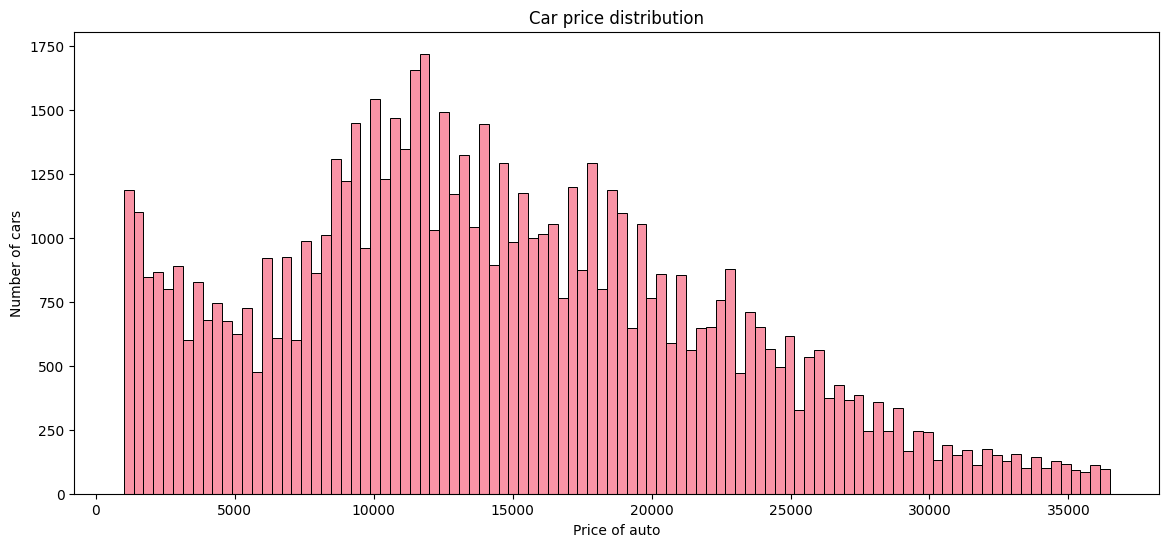

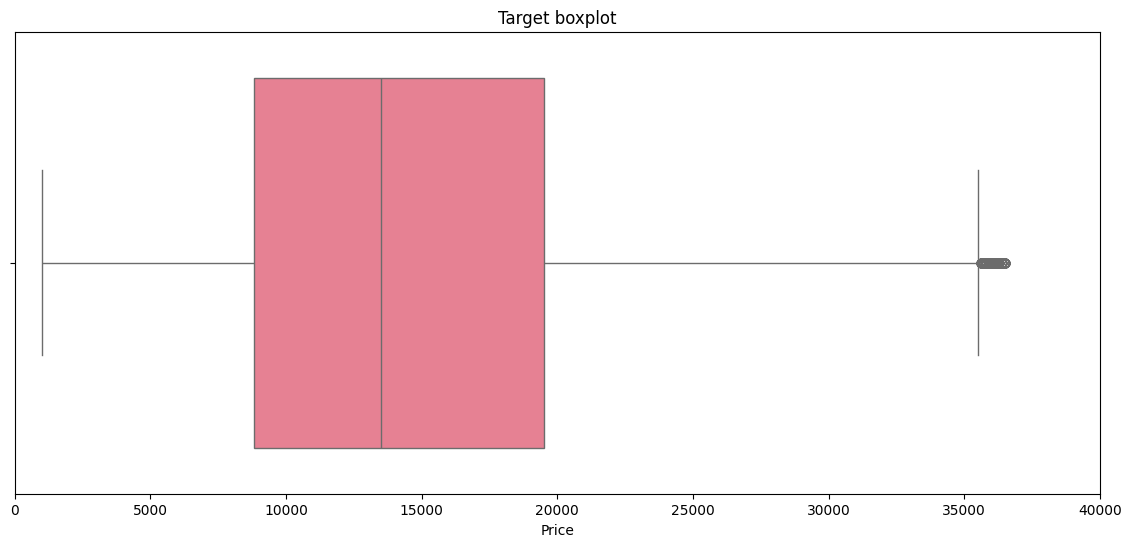

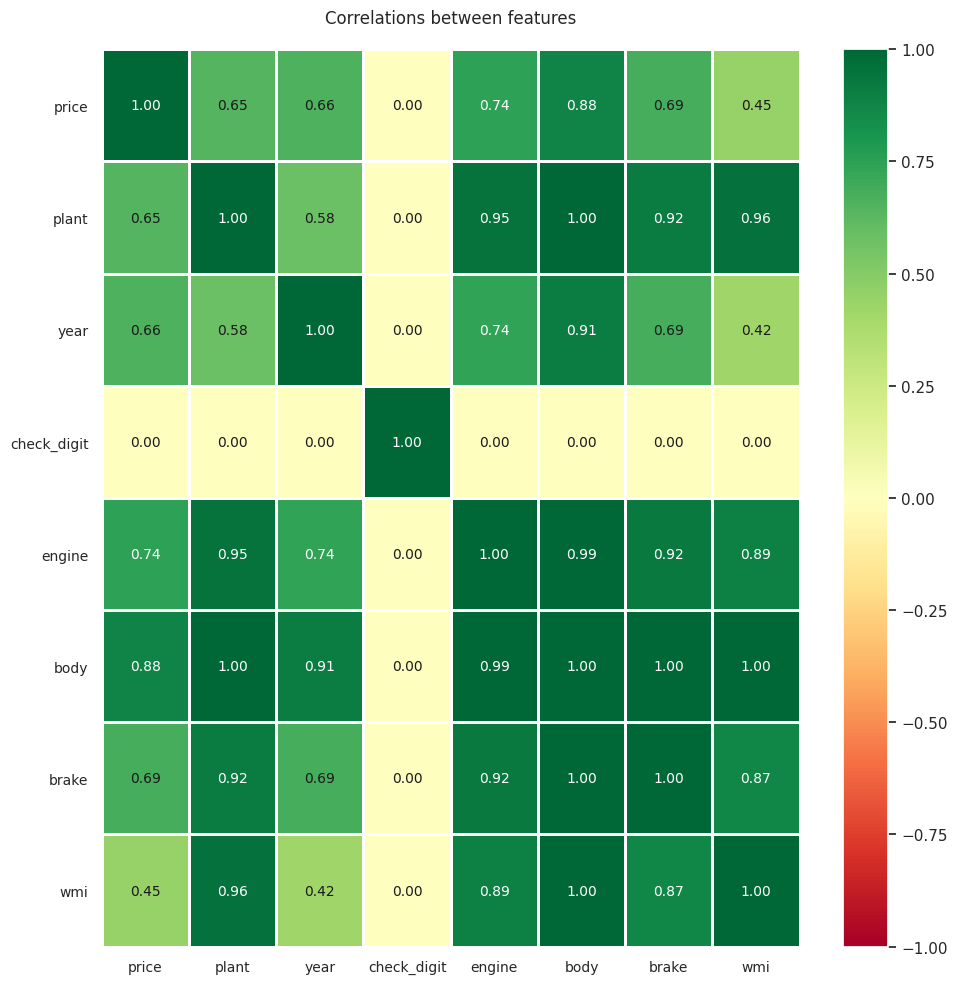

In [6]:
df = data_explorer.explore_dataset(assets_dir=ASSETS_DIR)

### Выводы и наблюдения
- на основании предоставленного файла создан датафрейм,
  <br>состоящий из частей VIN-кодов и цен автомобилей;
- общее количество записей в датафрейме - 71884;
- дубликатов не обнаружено;
- почти все признаки относятся к категориальным;
- цены на автомобили варьируются от 1000 до 36500 единиц,
  <br>с большинством автомобилей имеющих цену в диапазоне от 8800 до 19500 единиц;
- средняя цена находится близко к медианной цене, что может указывать на отсутствие сильных выбросов в данных -
  <br>данное предположение подтверждается диаграммой "ящик с усами";
- практически между всеми признаками имеются зависимости, возможно, над этим придётся поработать.

## Подготовка данных для обучения модели

In [7]:
X_train, X_test, y_train, y_test = data_explorer.data_preparing(dataset=df, target='price', test_size=0.2)

Размер обучающего набора данных: (57507, 8)
Размер тестового набора данных: (14377, 8)


### Выводы и наблюдения
- произведено разделение данных на выборки;
- произведено кодирование данных для моделей

## Обучение моделей

### Baseline

In [8]:
params = {'fit_intercept':True,
          'copy_X':True,
          'n_jobs':-1,
          'positive':False}
cv_res, model = data_explorer.model_fitting(model_name='Baseline', features=X_train, labels=y_train, params=params, cv=4)

Результаты кросс-валидации: {'fit_time': 0.021, 'score_time': 0.005, 'test_neg_mean_squared_error': 30475394.373, 'test_r2': 0.502, 'test_neg_mean_absolute_error': 4035.195, 'test_neg_mean_absolute_percentage_error': 0.581}


### Linear Regression

In [12]:
params = {'fit_intercept': [True, False],
          'copy_X': [True, False],
          'n_jobs': [-1],
          'positive': [True, False]}
cv_res, model, params = data_explorer.model_fitting(model_name='LinearRegression',
                                                    features=X_train,
                                                    labels=y_train,
                                                    params=params,
                                                    cv=4)

Результаты кросс-валидации: {'test_neg_mean_squared_error': 136230189.195, 'test_r2': -1.228, 'test_neg_mean_absolute_error': 9386.676, 'test_neg_mean_absolute_percentage_error': 1.069}

Лучшие гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}


### Random Forest

In [13]:
params = {'n_estimators': [100, 150],
          'criterion': ['squared_error', 'friedman_mse'],
          'max_depth': [None, 3, 5],
          'bootstrap': [True, False],
          'n_jobs': [-1],
          'random_state': [RANDOM_STATE]}
cv_res, model, params = data_explorer.model_fitting(model_name='RandomForest',
                                                    features=X_train,
                                                    labels=y_train,
                                                    params=params,
                                                    cv=4)

Результаты кросс-валидации: {'test_neg_mean_squared_error': 16800978.901, 'test_r2': 0.725, 'test_neg_mean_absolute_error': 2907.04, 'test_neg_mean_absolute_percentage_error': 0.337}

Лучшие гиперпараметры: {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 42}


### CatBoost

In [14]:
params = {'iterations': [100, 300],
          'learning_rate': [0.03, 0.1],
          'depth': [4, 8],
          'l2_leaf_reg': [1, 5]}
cv_res, model, params = data_explorer.model_fitting(model_name='CatBoost',
                                                    features=X_train,
                                                    labels=y_train,
                                                    params=params,
                                                    cv=4)


bestTest = 3863.351282
bestIteration = 99

0:	loss: 3863.3512819	best: 3863.3512819 (0)	total: 321ms	remaining: 4.81s

bestTest = 3232.654121
bestIteration = 99

1:	loss: 3232.6541207	best: 3232.6541207 (1)	total: 559ms	remaining: 3.91s

bestTest = 3864.033778
bestIteration = 99

2:	loss: 3864.0337776	best: 3232.6541207 (1)	total: 827ms	remaining: 3.58s

bestTest = 3243.236396
bestIteration = 99

3:	loss: 3243.2363964	best: 3232.6541207 (1)	total: 1.08s	remaining: 3.24s

bestTest = 3255.851674
bestIteration = 299

4:	loss: 3255.8516745	best: 3232.6541207 (1)	total: 1.78s	remaining: 3.93s

bestTest = 2958.849935
bestIteration = 299

5:	loss: 2958.8499348	best: 2958.8499348 (5)	total: 2.49s	remaining: 4.14s

bestTest = 3267.1275
bestIteration = 299

6:	loss: 3267.1275000	best: 2958.8499348 (5)	total: 3.2s	remaining: 4.12s

bestTest = 2974.545073
bestIteration = 299

7:	loss: 2974.5450731	best: 2958.8499348 (5)	total: 3.93s	remaining: 3.93s

bestTest = 3409.78264
bestIteration = 99

8:	l

Логирование модели и метрик

In [77]:
metadata = {
    'author': 'denis_zeit',
    'training_date': '2024-04-22',
    'data_used': 'wo_test_data',
    'library_versions': {'mlflow': '2.11.3',
                         'scikit-learn': '1.4.2',
                         'catboost': '1.2.5'}
}

data_explorer.model_logging(experiment_name=EXPERIMENT_NAME,
                            run_name=RUN_NAME[3],
                            registry_model=REGISTRY_MODEL_NAME[3],
                            params=params,
                            metrics=cv_res,
                            model=model,
                            train_data=X_train,
                            train_label=y_train,
                            metadata=metadata,
                            code_paths=['decoding_vin_codes.ipynb', 'research_class.py'],
                            tsh=TRACKING_SERVER_HOST,
                            tsp=TRACKING_SERVER_PORT,
                            assets_dir=ASSETS_DIR)

/home/denis/Documents/main_venv/vin_codes/.env_vin/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/denis/Documents/main_venv/vin_codes/.env_vin/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'catboost'.
2024/04/22 12:33:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: catboost, version 1
Created version '1' of model 'catboost'.


### Выводы и наблюдения
- в качестве `baseline` принята модель линейной регрессии с гиперпараметрами по умолчанию;
- обучена модель линейной регрессии с подбором гиперпараметров по сетке;
- обучена модель случайного леса с подбором гиперпараметров по сетке;
- обучена модель градиентного бустинга с подбором гиперпараметров по сетке;
- все модели с подобранными параметрами и метриками залогированы.

## Выбор лучшей модели

In [15]:
connection.update(postgres_credentials)
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
        table_data = []
        for table_name in cur.fetchall():
            cur.execute(f"SELECT COUNT(*) FROM {table_name[0]}")
            table_data.append((table_name[0], cur.fetchone()[0]))
        print('Находящиеся в базе таблицы:')
        display(pd.DataFrame(table_data, columns=['table_name', 'number_of_rows']))

        cur.execute("""
                       SELECT 
                         COALESCE(model_versions.name, 'baseline') AS model_name,
                         model_versions.version,
                         MAX(CASE WHEN metrics.key = 'test_neg_mean_squared_error' THEN metrics.value END) AS mse,
                         MAX(CASE WHEN metrics.key = 'test_r2' THEN metrics.value END) AS r2,
                         MAX(CASE WHEN metrics.key = 'test_neg_mean_absolute_error' THEN metrics.value END) AS mae,
                         MAX(CASE WHEN metrics.key = 'test_neg_mean_absolute_percentage_error' THEN metrics.value END) AS mape,
                         metrics.run_uuid
                       FROM metrics
                         LEFT JOIN model_versions ON model_versions.run_id=metrics.run_uuid
                       WHERE metrics.key NOT IN ('fit_time', 'score_time')
                       GROUP BY COALESCE(model_versions.name, 'baseline'), model_versions.version, metrics.run_uuid
                       ORDER BY mse
                       """)
        table_data = cur.fetchall()
        table_columns = [desc[0] for desc in cur.description]
        print('Модели и их метрики:')
        display(pd.DataFrame(table_data, columns=table_columns))

Находящиеся в базе таблицы:


,table_name,number_of_rows
0,experiments,2
1,tags,20
2,params,18
3,metrics,18
4,runs,4
5,alembic_version,1
6,experiment_tags,0
7,latest_metrics,18
8,registered_models,4
9,registered_model_tags,0


Модели и их метрики:


,model_name,version,mse,r2,mae,mape,run_uuid
0,catboost,1,2.791434e+03,0.881,1898.950,0.200,7642fc590c9e4622873d6a39a4ec049d
1,rendom_forest,1,1.680098e+07,0.725,2907.040,0.337,e6895207e058469fbcf64ed37c2bdce3
2,baseline,1,3.047539e+07,0.502,4035.195,0.581,3175f099d12941c3b1185f9675a15939
3,linear_regression,1,1.362302e+08,-1.228,9386.676,1.069,35f3d37e332e4b5791a5ad0ff3c0e919


### Выводы и наблюдения
- лучшие результаты на валидации показала модель `CatBoostRegressor`

## Тестирование модели на отложенной выборке

In [16]:
data_explorer.model_testing(model=model, test_features=X_test, test_labels=y_test)

MSE лучшей модели на отложенной выборке: 17631685.118
MAE лучшей модели на отложенной выборке: 3028.507
R2 лучшей модели на отложенной выборке: 0.714
MAPE лучшей модели на отложенной выборке: 0.338


### Выводы и наблюдения
- произведено тестирование лучшей модели на отложенной выборке;
- по результатам тестирования можно предположить, что переобучения модели не произошло,
  <br>дальнейших доработок модели на данном этапе не требуется.

## Проверка важности признаков

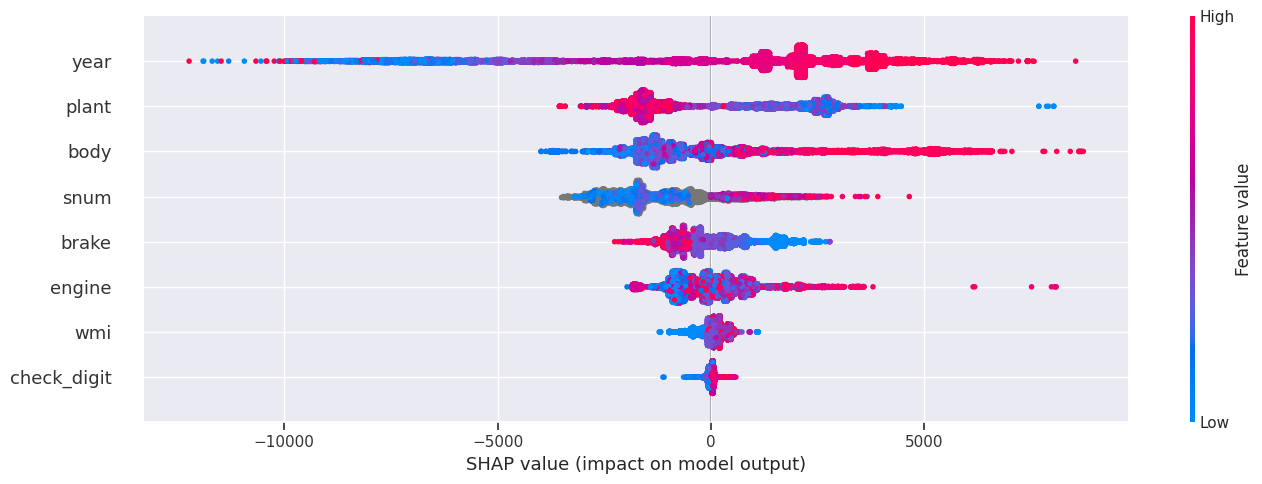

In [17]:
data_explorer.feature_importance(model=model, features=X_test, assets_dir=None)

### Выводы и наблюдения
- наиболее важными признаками для прогнозирования цены выделены:
  - год производства автомобиля;
  - завод-производитель автомобиля;
  - кузов автомобиля

## Отчёт по проведённому исследованию
**Загрузка данных и ознакомление с ними**

Выполнено

- данные загружены и изучены;
- составлено общее представление о необходимых действяих для обработки.

**Подготовка паттерна для парсинга данных**

Выполнено

- паттерн подготовлен и протестирован.

**Исследовательский анализ данных**

Выполнено

- исследованы общие параметры датафрейма, наличие дубликатов, типы признаков;
- исследована целевая переменная;
- изучены зависимости между признаками.

**Подготовка данных для обучения моделей**

Выполнено

- произведено разделение данных на обучающую и тестовую выборки;
- признаки в выборках закодированы и масштабированы.

**Обучение моделей**

Выполнено

Обучены и оценены модели:

- `Linear Regression` без подбора гиперпараметров - в качестве `baseline`;
- `Linear Regression` с подбором гиперпараметров `GridSearch`;
- `Random Forest Regressor` с подбором гиперпараметров `GridSearch`;
- `CatBoost Regressor` с подбором гиперпараметров `GridSearch`.

**Выбор лучшей модели**

Выполнено

- по метрике `MSE` лучший результат на валидации показала модель `CatBoost Regressor`

**Тестирование модели**

Выполнено

- проверка на тестовой выборке показала адекватность обучения модели

**Анализ важности признаков лучшей модели**

Выполнено

Наиболее важными признаками для прогнозирования цены выделены:
- год производства автомобиля;
- завод-производитель автомобиля;
- кузов автомобиля

**Дополнительно**
- поднята база PostgreSQL для хранения метрик и параметров моделей;
- поднят MLflow server для логирования моделей, параметров и метрик.

**Общий итог: для выполнения поставленной задачи наиболее подходящей моделью оказалась модель градиентного бустинга `CatBoost`**